In [1]:
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torch.autograd as autograd
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.gridspec as gridspec
from IPython.display import HTML

from PIL import Image

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2


In [2]:
# Root directory for dataset
dataroot = "/home/ubuntu/exp/swivel/data/shapenet/shapenet_images_128_1.5/02691156"

# Number of workers for dataloader
workers = 1

# Batch size during training
batch_size = 64

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 128

# Number of channels in the training images. For color images this is 3
nc = 4

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Number of training epochs
num_epochs = 500

# Learning rate for optimizers
lr_D = 0.00002
lr_G = 0.001
lr_R = lr_G

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5
beta2 = 0.999

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

resume = True

checkpoint_file = 'swivel_take9_qp_lap_recon_flatten_0002_fem.pth'

lap_loss_on = True


def show_images(images):
    images = images[:, :3] 
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(np.transpose(img, (1,2,0)))
#         plt.imshow(img.reshape([image_size, image_size, 3]))
    return 

In [3]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset

def pil_alpha_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGBA')
    
    
dataset = dset.ImageFolder(root=dataroot,
            transform=transforms.ToTensor(),
            loader = pil_alpha_loader,
        )
num_data = len(dataset) - len(dataset) % batch_size
print(num_data)
                
# Create the dataloader
prelim_dataloader = torch.utils.data.DataLoader(dataset, batch_size=num_data,
                                         shuffle=True, num_workers=0)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Retrieve all data
total_batch = next(iter(prelim_dataloader))
# plt.figure(figsize=(8,600))
# plt.axis("off")
# plt.title("Training Images")
# plt.imshow(np.transpose(vutils.make_grid(total_batch[0].to(device)[:num_data], padding=2, normalize=True).cpu(),(1,2,0)))

4032


In [4]:
dataset_tensor = total_batch[0]
print(dataset_tensor.shape)

torch.Size([4032, 4, 128, 128])


In [5]:
from torch.utils.data import TensorDataset

tensor_dataset = TensorDataset(dataset_tensor)
print(len(tensor_dataset))

dataloader = torch.utils.data.DataLoader(tensor_dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=0, pin_memory=True
                                        )



4032


In [6]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [7]:
from models import RenderedGenerator, Discriminator, ReverseGenerator

netG = RenderedGenerator(batch_size=batch_size, z_dim=nz, image_size=image_size, random_pose=True).cuda()
netG.apply(weights_init)

netD = Discriminator(image_size=image_size, image_channels=4).cuda()
netD.apply(weights_init)

netR = ReverseGenerator(batch_size=batch_size, z_dim=nz).cuda()
netR.apply(weights_init)

ReverseGenerator(
  (fc1): Linear(in_features=1024, out_features=100, bias=True)
  (bn2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (bn3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=1024, out_features=1024, bias=True)
  (bn4): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=1926, out_features=1024, bias=True)
  (relu): LeakyReLU(negative_slope=0.2, inplace)
)

In [8]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in netG.state_dict():
    print(param_tensor, "\t", netG.state_dict()[param_tensor].size())

Model's state_dict:
mesh_generator.fc1.weight 	 torch.Size([1024, 100])
mesh_generator.fc1.bias 	 torch.Size([1024])
mesh_generator.bn1.weight 	 torch.Size([1024])
mesh_generator.bn1.bias 	 torch.Size([1024])
mesh_generator.bn1.running_mean 	 torch.Size([1024])
mesh_generator.bn1.running_var 	 torch.Size([1024])
mesh_generator.bn1.num_batches_tracked 	 torch.Size([])
mesh_generator.fc2.weight 	 torch.Size([1024, 1024])
mesh_generator.fc2.bias 	 torch.Size([1024])
mesh_generator.bn2.weight 	 torch.Size([1024])
mesh_generator.bn2.bias 	 torch.Size([1024])
mesh_generator.bn2.running_mean 	 torch.Size([1024])
mesh_generator.bn2.running_var 	 torch.Size([1024])
mesh_generator.bn2.num_batches_tracked 	 torch.Size([])
mesh_generator.fc_bias.weight 	 torch.Size([1926, 1024])
mesh_generator.fc_bias.bias 	 torch.Size([1926])


In [9]:

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.Tensor(batch_size, nz).normal_(0,1).cuda()

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizer_D = optim.Adam(netD.parameters(), lr=lr_D, betas=(beta1, beta2))
optimizer_G = optim.Adam(netG.parameters(), lr=lr_G, betas=(beta1, beta2))
optimizer_R = optim.Adam(netR.parameters(), lr=lr_R, betas=(beta1, beta2))

In [10]:
# Training Loop
NORM = 'l2'

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
R_losses = []
Lap_losses = []
iters = 0

adversarial_loss = nn.BCEWithLogitsLoss()

from soft_renderer import LaplacianLoss, FlattenLoss

laplacian_loss = LaplacianLoss(netG.mesh_generator.sphere_vs.cpu(), netG.sphere_fs[0].cpu()).cuda()
flatten_loss = FlattenLoss(netG.sphere_fs[0].cpu()).cuda()


# Loss weight for gradient penalty
threshold_lap = 0.5


z_recon_cross_entropy = nn.BCEWithLogitsLoss() 



Starting Training Loop...
[Epoch 0/500] [Batch 0/63] [D loss: -3.087099][G loss: 6.297700][Lap loss: 154.134979][flatten loss: 24.731270] D(x): 4.5825 D(G(z)): -1.8066/-1.8119


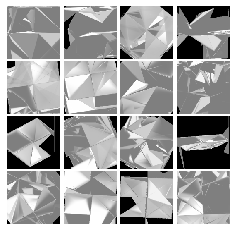

[Epoch 1/500] [Batch 0/63] [D loss: -2.770864][G loss: 5.590190][Lap loss: 103.240585][flatten loss: 18.379545] D(x): 4.6768 D(G(z)): -1.0014/-0.8971
[Epoch 2/500] [Batch 0/63] [D loss: -2.895418][G loss: 6.003971][Lap loss: 94.322449][flatten loss: 16.794607] D(x): 4.5907 D(G(z)): -1.5009/-1.5076
[Epoch 3/500] [Batch 0/63] [D loss: -2.890639][G loss: 5.865735][Lap loss: 93.013634][flatten loss: 16.251324] D(x): 4.4114 D(G(z)): -1.3640/-1.3787
[Epoch 4/500] [Batch 0/63] [D loss: -2.957717][G loss: 6.311485][Lap loss: 89.718735][flatten loss: 15.395277] D(x): 4.4568 D(G(z)): -2.0225/-1.9098
[Epoch 5/500] [Batch 0/63] [D loss: -3.169621][G loss: 6.338952][Lap loss: 88.026558][flatten loss: 15.868478] D(x): 4.0730 D(G(z)): -2.1859/-2.1572
[Epoch 6/500] [Batch 0/63] [D loss: -2.936346][G loss: 5.808372][Lap loss: 81.954041][flatten loss: 13.637074] D(x): 4.0176 D(G(z)): -1.8374/-1.8119
[Epoch 7/500] [Batch 0/63] [D loss: -2.853681][G loss: 5.369634][Lap loss: 78.914413][flatten loss: 13.32

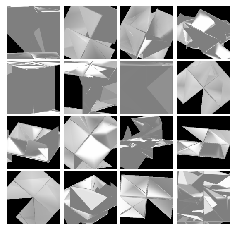

[Epoch 8/500] [Batch 0/63] [D loss: -3.091021][G loss: 6.001941][Lap loss: 80.499359][flatten loss: 13.379473] D(x): 3.6482 D(G(z)): -2.0672/-2.0883
[Epoch 9/500] [Batch 0/63] [D loss: -3.207153][G loss: 6.027959][Lap loss: 78.847389][flatten loss: 13.199605] D(x): 3.8354 D(G(z)): -1.9755/-2.1415
[Epoch 10/500] [Batch 0/63] [D loss: -3.066142][G loss: 5.923286][Lap loss: 74.968460][flatten loss: 12.501441] D(x): 3.9040 D(G(z)): -2.0297/-2.0694
[Epoch 11/500] [Batch 0/63] [D loss: -2.958592][G loss: 6.050799][Lap loss: 79.216805][flatten loss: 13.897143] D(x): 3.7923 D(G(z)): -1.9452/-2.2051
[Epoch 12/500] [Batch 0/63] [D loss: -2.948584][G loss: 5.848203][Lap loss: 73.434082][flatten loss: 11.893233] D(x): 3.6357 D(G(z)): -2.0652/-2.0871
[Epoch 13/500] [Batch 0/63] [D loss: -3.125699][G loss: 6.003067][Lap loss: 70.313965][flatten loss: 11.346319] D(x): 3.8020 D(G(z)): -2.3793/-2.2751
[Epoch 14/500] [Batch 0/63] [D loss: -3.075982][G loss: 6.207501][Lap loss: 74.589119][flatten loss: 1

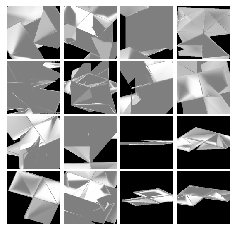

[Epoch 16/500] [Batch 0/63] [D loss: -3.035173][G loss: 6.041546][Lap loss: 68.937973][flatten loss: 11.024947] D(x): 3.5882 D(G(z)): -2.4809/-2.6610
[Epoch 17/500] [Batch 0/63] [D loss: -3.056764][G loss: 5.924086][Lap loss: 73.876099][flatten loss: 11.909699] D(x): 3.4290 D(G(z)): -2.6271/-2.6950
[Epoch 18/500] [Batch 0/63] [D loss: -3.139860][G loss: 5.736898][Lap loss: 70.215675][flatten loss: 11.216010] D(x): 3.4386 D(G(z)): -2.8840/-2.7942


In [ ]:
lambda_lap = 0.5
lambda_z_recon = 10
lambda_g = 1
lambda_flat = 0.01



if os.path.exists(checkpoint_file):
    if resume:
        checkpoint = torch.load(checkpoint_file)
        netD.load_state_dict(checkpoint['netD'])
        netG.load_state_dict(checkpoint['netG'])
        netR.load_state_dict(checkpoint['netR'])
        optimizer_D.load_state_dict(checkpoint['optimizer_D'])
        optimizer_G.load_state_dict(checkpoint['optimizer_G'])
        optimizer_R.load_state_dict(checkpoint['optimizer_R'])

print("Starting Training Loop...")
# For each epoch
lap_initialized = False

for epoch in range(num_epochs):
    # For each batch in the dataloader
    #last_g_error = 1.0
    for i, data in enumerate(dataloader, 0):
        
        batch = data[0]
        batch_size_i = batch.shape[0]
        # Adversarial ground truths
        valid = torch.cuda.FloatTensor(batch_size_i, 1).fill_(real_label)
        fake = torch.cuda.FloatTensor(batch_size_i, 1).fill_(fake_label)
        # Configure input
        #noise = torch.cuda.Tensor(*batch.shape).normal_(0.0, 0.05)
        real_imgs = batch.cuda() - 0.5 #+ noise

        # -----------------
        #  Train Generator
        # -----------------
        
        optimizer_G.zero_grad()
        optimizer_R.zero_grad()

        # Sample noise as generator input
        z = torch.Tensor(batch_size_i, nz).normal_(0,1).cuda()

        # Generate a batch of images
        gen_imgs, gen_verts = netG(z)
        gen_imgs -= 0.5 #normalize
        
        # Loss measures generator's ability to fool the discriminator
        #g_loss = ls_generator_loss(netD(gen_imgs))
        fake_logits_g = netD(gen_imgs)
        real_logits_g = netD(real_imgs)
        
        #z_recon = netR(gen_verts)
        #r_loss = (torch.mean((z_recon - z) ** 2)) * lambda_z_recon #+ z_H)* lambda_z_recon
        
        g_adv_loss = (real_logits_g - fake_logits_g).mean() * lambda_g
        
        lap_loss = laplacian_loss(gen_verts).mean() * lambda_lap
        flat_loss = flatten_loss(gen_verts).mean() * lambda_flat
        
        
        
        g_loss = g_adv_loss + lap_loss + flat_loss #+ r_loss #(lap_loss if lap_loss_on and lap_loss.item() > threshold_lap else 0)

        g_loss.backward()
        optimizer_G.step()
        optimizer_R.step()
        
        G_losses.append(g_adv_loss.item())
        #R_losses.append(r_loss.item())

        # ---------------------
        #  Train Discriminator
        # ---------------------
        
        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        x_gen = gen_imgs.detach()
        real_logits_d = netD(real_imgs)
        fake_logits_d = netD(x_gen)
        

#         real_loss = adversarial_loss(real_logits, valid)
#         fake_loss = adversarial_loss(fake_logits_d, fake)
        #d_loss = ls_discriminator_loss(netD(real_imgs), netD(gen_imgs.detach()))
        #d_loss = (real_loss + fake_loss) / 2 #* (torch.abs(fake_logits_d.mean()) + torch.abs(real_logits.mean()) + torch.abs(fake_logits_g.detach().mean()))/3
        
        
        # Compute loss
        d_loss = real_logits_d - fake_logits_d
        if NORM == 'l1':
            d_norm = 10 * (real_imgs - x_gen).abs().mean()
        elif NORM == 'l2':
            d_norm = 10 * ((real_imgs - x_gen)**2).mean().sqrt()
        d_loss = - d_loss + 0.5 * d_loss**2 / d_norm
        d_loss = d_loss.mean()
        
        
        d_loss.backward()
        
#         if lap_loss_on:
#             if lap_loss.item() < threshold_lap:
#                 if not lap_initialized:
#                     lap_initialized = True
#                     print("Laplacian has been initialized. Discriminator will begin training.")

#             if lap_initialized:# and g_adv_loss.item() < 20.0:
#                 optimizer_D.step()
#         else:
        optimizer_D.step()
            
            
        D_losses.append(d_loss.item())
        
        #Lap_losses.append(lap_loss.item())

        if i == 0:
            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f][G loss: %f][Lap loss: %f][flatten loss: %f] D(x): %.4f D(G(z)): %.4f/%.4f"
                % (epoch, num_epochs, i, len(dataloader), d_loss.item(), g_adv_loss.item(),
                lap_loss.item(), flat_loss.item(), real_logits_d.mean().item(), fake_logits_d.mean().item(),
                fake_logits_g.mean().item())
            )
            
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise)[0][:,:3].detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            imgs_numpy = fake.numpy()
            show_images(imgs_numpy[0:16])
            plt.show()
        
        iters += 1
    
    torch.save({
        'netD': netD.state_dict(),
        'netG': netG.state_dict(),
        'netR': netR.state_dict(),
        'optimizer_D': optimizer_D.state_dict(),
        'optimizer_G': optimizer_G.state_dict(),
        'optimizer_R': optimizer_R.state_dict(),
    }, checkpoint_file)

       
 #         ############################
#         # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
#         ###########################
#         ## Train with all-real batch
#         netD.zero_grad()
#         # Format batch
#         real_cpu = data[0].cuda()
#         b_size = real_cpu.size(0)
#         label = torch.full((b_size,), real_label).cuda()
#         # Forward pass real batch through D
#         real_logits = netD(real_cpu).view(-1)
#         # Calculate loss on all-real batch
#         #errD_real = criterion(output, label)
#         # Calculate gradients for D in backward pass
#         #errD_real.backward()
#         D_x = real_logits.mean().item()

        
#          ## Train with all-fake batch
#         # Generate batch of latent vectors
#         noise = torch.randn(batch_size, nz).cuda()
#         # Generate fake image batch with G
#         fake, generated_vertices = netG(noise)
        
#         label.fill_(fake_label)
#         # Classify all fake batch with D
#         fake_logits = netD(fake.detach()).view(-1)
#         # Calculate D's loss on the all-fake batch
#         #errD_fake = criterion(output, label)
#         #logits_fake = D(fake_images.view(batch_size, 1, 28, 28))
#         d_total_error = ls_discriminator_loss(real_logits, fake_logits)

#         D_G_z1 = fake_logits.mean().item()
#         # Add the gradients from the all-real and all-fake batches
#         #errD = errD_real + errD_fake
#         # Update D
#         # Calculate the gradients for this batch
#         d_total_error.backward()
#         optimizerD.step()

        
#         ############################
#         # (2) Update G network: maximize log(D(G(z)))
#         ###########################
#         netG.zero_grad()
#         label.fill_(real_label)  # fake labels are real for generator cost
#         # Since we just updated D, perform another forward pass of all-fake batch through D
#         g_logits = netD(fake).view(-1)
#         # Calculate G's loss based on this output
#         #errG = criterion(output, label)
#         # Calculate gradients for G
#         g_total_error = ls_generator_loss(g_logits)
#         g_total_error.backward()
#         D_G_z2 = g_logits.mean().item()
#         # Update G
#         optimizerG.step()
#         #last_g_error = g_total_error

#         # Output training stats
#         if i % 50 == 0:
#             print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
#                   % (epoch, num_epochs, i, len(dataloader),
#                      d_total_error.item(), g_total_error.item(), D_x, D_G_z1, D_G_z2))

#         # Save Losses for plotting later
#         G_losses.append(d_total_error.item())
#         D_losses.append(g_total_error.item())

#         # Check how the generator is doing by saving G's output on fixed_noise
#         if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
#             with torch.no_grad():
#                 fake = netG(fixed_noise)[0][:,:3].detach().cpu()
#             img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

#        iters += 1

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(60,60))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:batch_size, :3], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-5],(1,2,0)))
plt.show()

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.plot(R_losses,label="R")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()